In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split,GridSearchCV
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import StandardScaler,LabelEncoder
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import RFE
from sklearn.model_selection import LeaveOneOut,cross_val_score,KFold
from sklearn.linear_model import LinearRegression,ElasticNetCV,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
sal_df = pd.read_csv('salary.csv',index_col=0)
sal_df.head()

,Customer_id,day_diff,sal_amt,annual_salary,Age,Sex,Acc_Balance,C_lat,C_long,C_loc
0,CUS-1462656821,14,3903.95,101851.267,23,M,15523.690,-33.76,151.27,NSW
1,CUS-2500783281,7,1626.48,84867.403,23,F,10832.200,-37.93,145.01,VIC
2,CUS-326006476,7,983.36,51310.320,22,M,8307.525,-33.80,151.18,NSW
3,CUS-1433879684,14,1408.08,36735.801,24,M,3874.970,-37.83,145.00,VIC
4,CUS-4123612273,7,1068.04,55728.801,43,F,5011.890,-37.76,144.95,VIC


In [3]:
sal_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Customer_id    100 non-null    object 
 1   day_diff       100 non-null    int64  
 2   sal_amt        100 non-null    float64
 3   annual_salary  100 non-null    float64
 4   Age            100 non-null    int64  
 5   Sex            100 non-null    object 
 6   Acc_Balance    100 non-null    float64
 7   C_lat          100 non-null    float64
 8   C_long         100 non-null    float64
 9   C_loc          100 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 8.6+ KB


In [4]:
sal_df = sal_df.drop(columns=['C_lat','C_long'],axis=1)

## Univariate Analysis

### Distribution of the numerical variables - age and annual salary

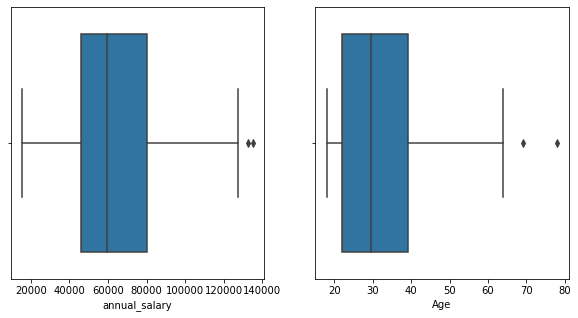

In [5]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.boxplot(sal_df['annual_salary'],ax=ax[0])
sns.boxplot(sal_df['Age'],ax=ax[1])
plt.show()

### Detection of outliers

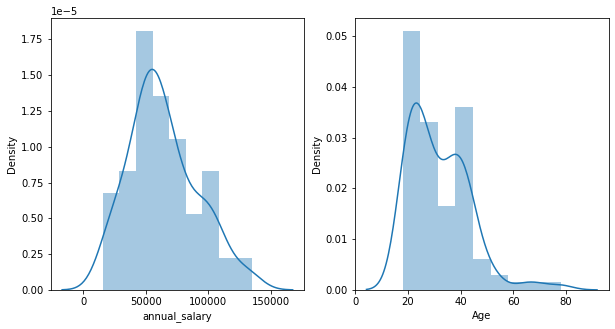

In [6]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.distplot(sal_df['annual_salary'],ax=ax[0])
sns.distplot(sal_df['Age'],ax=ax[1])
plt.show()

### Count of the categorical varibles

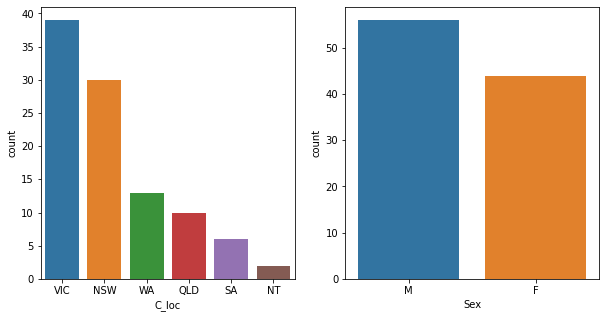

From the fig-1 we get to see that most of the customers are residing in VIC
From the fig-2 we get to see that count of male customers are more in number compared to females


In [7]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.countplot(sal_df['C_loc'],ax=ax[0],order = sal_df['C_loc'].value_counts().index)
sns.countplot(sal_df['Sex'],ax=ax[1], order = sal_df['Sex'].value_counts().index)
plt.show()
print("From the fig-1 we get to see that most of the customers are residing in VIC")
print("From the fig-2 we get to see that count of male customers are more in number compared to females")

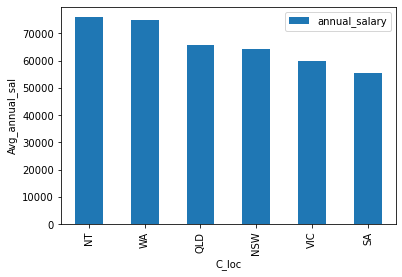

Customers who all are staying in NT are having higher avg annual salaries


In [8]:
sal_df.groupby('C_loc')[['annual_salary']].mean().sort_values(by='annual_salary',ascending = False).plot(kind='bar')
plt.ylabel('Avg_annual_sal')
plt.show()
print('Customers who all are staying in NT are having higher avg annual salaries')

In [9]:
sal_df.groupby('Sex',as_index = False)[['annual_salary']].mean()

,Sex,annual_salary
0,F,60997.711773
1,M,66085.367464


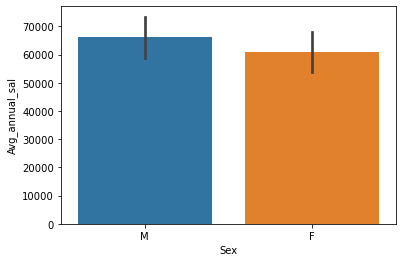

Females are getting less average annual salary compared to males


In [10]:
sns.barplot(x=sal_df['Sex'],y= sal_df['annual_salary'])
plt.xlabel('Sex')
plt.ylabel('Avg_annual_sal')
plt.show()
print('Females are getting less average annual salary compared to males')

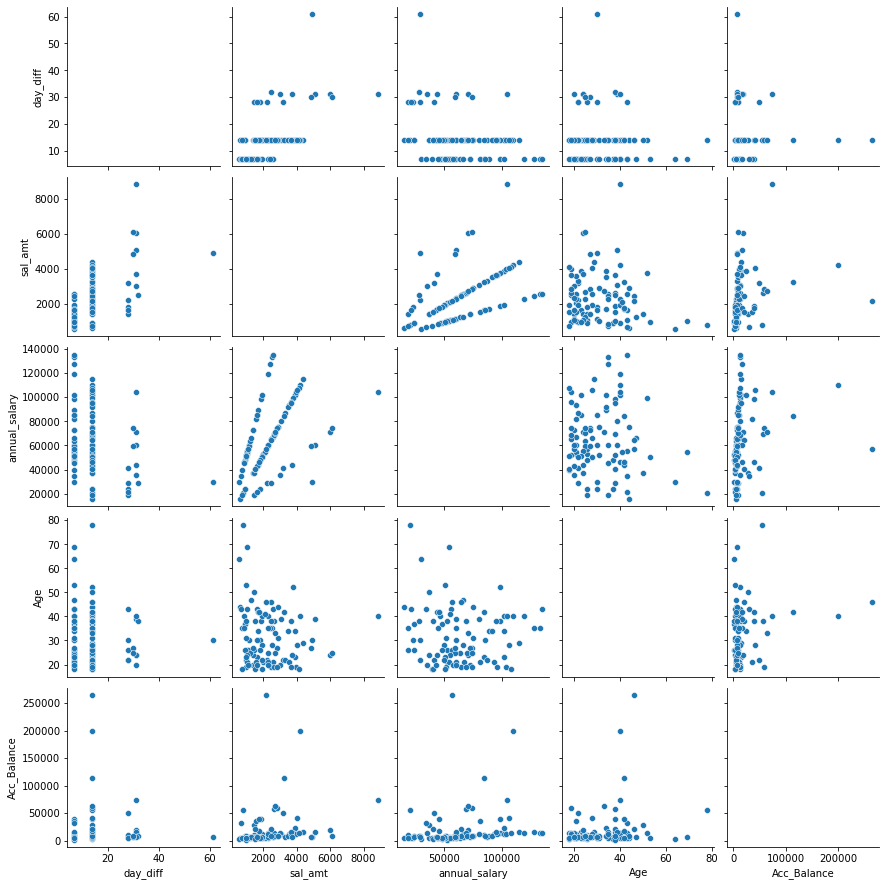

In [11]:
sns.pairplot(sal_df,diag_kind= True)
plt.show()

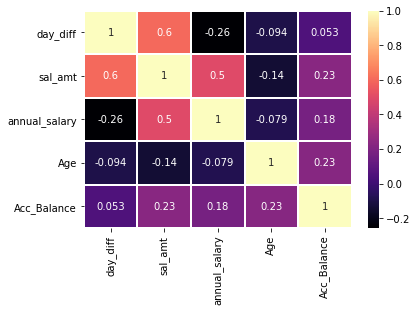

In [12]:
sns.heatmap(sal_df.corr(),annot=True,linewidths=1,cmap='magma')
plt.show()

In [13]:
num_df = sal_df.select_dtypes(np.number)
num_df.columns

Index(['day_diff', 'sal_amt', 'annual_salary', 'Age', 'Acc_Balance'], dtype='object')

In [14]:
std_sc = StandardScaler()
num_std = std_sc.fit_transform(num_df)
num_std = pd.DataFrame(num_std,columns=num_df.columns)
num_std.head(3)

,day_diff,sal_amt,annual_salary,Age,Acc_Balance
0,-0.008258,1.155236,1.403453,-0.763512,-0.093792
1,-0.834105,-0.482316,0.776262,-0.763512,-0.226597
2,-0.834105,-0.944733,-0.462955,-0.850572,-0.298064


In [15]:
cat_df = sal_df.select_dtypes('object').drop('Customer_id',axis=1)
cat_df.columns

Index(['Sex', 'C_loc'], dtype='object')

In [16]:
le = LabelEncoder()
cat_df = cat_df.apply(le.fit_transform)
cat_df.head()

,Sex,C_loc
0,1,0
1,0,4
2,1,0
3,1,4
4,0,4


In [27]:
df =  pd.concat([num_std,cat_df],axis=1)
df.head()

,day_diff,sal_amt,annual_salary,Age,Acc_Balance,Sex,C_loc
0,-0.008258,1.155236,1.403453,-0.763512,-0.093792,1,0
1,-0.834105,-0.482316,0.776262,-0.763512,-0.226597,0,4
2,-0.834105,-0.944733,-0.462955,-0.850572,-0.298064,1,0
3,-0.008258,-0.639350,-1.001172,-0.676453,-0.423539,1,4
4,-0.834105,-0.883847,-0.299787,0.977679,-0.391355,0,4


In [28]:
x = df.drop('annual_salary',axis=1)
y = sal_df['annual_salary']

In [29]:
Xc = sm.add_constant(x)
x_train,x_test,y_train,y_test = train_test_split(Xc,y,test_size=0.3,random_state=10)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((70, 7), (30, 7), (70,), (30,))

### Linear Regression

In [38]:
lin_reg = sm.OLS(y_train,x_train).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          annual_salary   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     33.59
Date:                Thu, 01 Jul 2021   Prob (F-statistic):           7.57e-18
Time:                        22:20:28   Log-Likelihood:                -764.41
No. Observations:                  70   AIC:                             1543.
Df Residuals:                      63   BIC:                             1559.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.477e+04   3410.224     18.993      0.000     5.8e+04    7.16e+04
day_diff    -2.416e+04   2000.556    -12.076      0.000   -2.82e+04   -2.02e+04
sal_amt      3.179e+04   2492.994     12.751      0.000    2.68e+04    3.68e+04
Age           201.8266   1839.390      0.110      0.913   -3473.901    3877.554
Acc_Balance  -204.8780   1621.144     -0.126      0.900   -3444.476    3034.720
Sex           911.1940   3399.165      0.268      0.790   -5881.495    7703.883
C_loc         -44.0377    879.341     -0.050      0.960   -1801.260    1713.185
==============================================================================
Omnibus:                       27.589   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.946
Skew:                           1.432   Prob(JB):                     2.35e-11
Kurtosis:                       5.930   Cond. No.                         8.55
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
y_pred = lin_reg.predict(x_test)
mse = mean_squared_error(y_test,y_pred)
print('Mean squared error:',mse)
rmse = np.sqrt(mse)
print('Root Mean squared error of testing set:',rmse)

Mean squared error: 236826194.7918777
Root Mean squared error of testing set: 15389.15835229067


In [64]:
print("R-squared:{:.3f}".format(round(lin_reg.rsquared,2)))
print("Adjusted R-squared:{:.3f}".format(round(lin_reg.rsquared_adj,2)))

R-squared:0.760
Adjusted R-squared:0.740


### Decision Tree Regressor

In [43]:
dtree = DecisionTreeRegressor(max_depth=5)
dt_model = dtree.fit(x_train,y_train)

In [47]:
y_pred = dt_model.predict(x_test)
mse = mean_squared_error(y_test,y_pred)
print('Mean squared error:',mse)
rmse = np.sqrt(mse)
print('Root Mean squared error of testing set:',rmse)

Mean squared error: 308088911.77080894
Root Mean squared error of testing set: 17552.46170116343


In [51]:
dt_model.score(x_test,y_test)

0.5478075729811323

In [65]:
from sklearn import tree

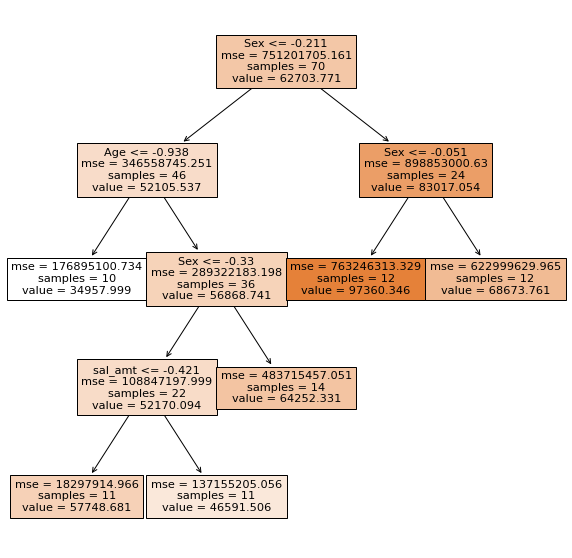

In [75]:
plt.figure(figsize=(10,10))
tree.plot_tree(dt_model,filled=True,feature_names=x.columns)
plt.show()